# Homework 4 #
**Name:** Andrea Gonzalez Cruz

**e-mail:** andrea.gcruz@alumnos.udg.mx

## Modules and Class Vector ##
Import/add the modules for the next sections.

In [16]:
import panel as pn #This library helps in the development of dashboards
import panel.widgets as pnw
import pandas as pd
import numpy as np
import plotly.graph_objects as go
pn.extension('plotly')
import math
import matplotlib.pyplot as plt

In [17]:
################# http://www.pygame.org/wiki/2DVectorClass ##################
class Vec2d(object):
    __slots__ = ['x', 'y']

    def __init__(self, x_or_pair, y = None):
        if y == None:            
            self.x = x_or_pair[0]
            self.y = x_or_pair[1]
        else:
            self.x = x_or_pair
            self.y = y
            
    #Addition
    def __add__(self, other):
        if isinstance(other, Vec2d):
            return Vec2d(self.x + other.x, self.y + other.y)
        elif hasattr(other, "__getitem__"):
            return Vec2d(self.x + other[0], self.y + other[1])
        else:
            return Vec2d(self.x + other, self.y + other)

    #Subtraction
    def __sub__(self, other):
        if isinstance(other, Vec2d):
            return Vec2d(self.x - other.x, self.y - other.y)
        elif (hasattr(other, "__getitem__")):
            return Vec2d(self.x - other[0], self.y - other[1])
        else:
            return Vec2d(self.x - other, self.y - other)
    
    #Vector length
    def get_length(self):
        return math.sqrt(self.x**2 + self.y**2)
    
    #Rotate vector
    def rotated(self, angle):        
        cos = math.cos(angle)
        sin = math.sin(angle)
        x = self.x*cos - self.y*sin
        y = self.x*sin + self.y*cos
        return Vec2d(x, y)

## Functions ##
These functions returns the different types of trajectories seen in the semester: **Brownian Motion (BM)**, **Correlated Random Walk (CRW)** and **Lévy Flight (LF)**.

*Instructions*
1. Functions that return the different types of trajectories.
2. All functions must take as arguments the **number of steps, speed**, and **starting position**.
3. **CRW** and **LF** functions must also take as an argument the **Cauchy Coefficient**.

In [18]:
#Add the trajectory function for the Brownian Motion (BM)
def bm(steps, speed, start_pos):
    pos = [np.array(start_pos)]
    for _ in range(steps):
        direction = np.random.normal(0, 1, 3)
        direction /= np.linalg.norm(direction)
        pos.append(pos[-1] + speed * direction)
    return np.array(pos)

#Add the trajectory function for the Correlated Random Walk (CRW)
def crw(steps, speed, start_pos, cauchy_c):
    pos = [np.array(start_pos)]
    direction = np.random.normal(0, 1, 3)
    direction /= np.linalg.norm(direction)
    for _ in range(steps):
        new_direction = direction + cauchy_c * np.random.normal(0, 1, 3)
        new_direction /= np.linalg.norm(new_direction)
        pos.append(pos[-1] + speed * new_direction)
        direction = new_direction
    return np.array(pos)

#Add the trajectory function for the Lévy Flight
def levy_f(steps, speed, start_pos, cauchy_c, alpha):
    pos = [np.array(start_pos)]
    direction = np.random.normal(0, 1, 3)
    direction /= np.linalg.norm(direction)
    for _ in range(steps):
        step_length = (np.random.pareto(alpha) + 1) * speed
        new_direction = direction + cauchy_c * np.random.normal(0, 1, 3)
        new_direction /= np.linalg.norm(new_direction)
        pos.append(pos[-1] + step_length * new_direction)
        direction = new_direction
    return np.array(pos)

## Metrics ##
For compute the metrics, we are including the **Path Lenght (PL)**, **Meand Squared Displacement (MSD)** and **Turning Angle Distribution (TAD)**. Each metric will be displayed in the dashboard.

In [27]:
#Define the Path Lenght (PL) function for the metrics
def path_l(trajectory):
    return np.sum(np.linalg.norm(np.diff(trajectory, axis=0), axis=1))

#Define the Mean Squared Displacement (MSD) for the metrics
def mean_squared(trajectory):
    n = len(trajectory)
    msd = []
    for lag in range(1, n):
        diffs = trajectory[lag:] - trajectory[:-lag]
        msd.append(np.mean(np.sum(diffs**2, axis=1)))
    return msd

#Define the Turning Angle Distribution (TAD) function for the metrics
def turning_angle(trajectory):
    diffs = np.diff(trajectory, axis=0)
    diffs = diffs / np.linalg.norm(diffs, axis=1)[:, None]
    angles = []
    for i in range(1, len(diffs)):
        cos_theta = np.clip(np.dot(diffs[i-1], diffs[i]), -1.0, 1.0)
        angles.append(np.degrees(np.arccos(cos_theta)))
    return angles

## Plot trajectories and metrics ##
The plot_trajectory help us to create a 3D plot for the **BM**, **CRW** and **LF** functions. The figure is return in the dashboard. Also, the plot_metric creates a similar plot using the **PL**, **MSD** and **TAD** metrics in the previus steps.

In [28]:
#Plot the functions (BM, CRW & LF)
def plot_trajectory(trajectory, traj_type):
    fig = plt.figure(figsize=(5, 4))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2], color='blue')
    ax.set_title(f"{traj_type} trajectory in 3D")
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_zlabel('time (s)')
    plt.tight_layout()
    plt.close(fig) #Avoid to plot other figure in the dashboard
    return fig

#Plot the metrics (PL, MSD & TAD)
def plot_metric(trajectory, metric_type, traj_type):
    fig, ax = plt.subplots(figsize=(5, 4))

    #Plot the PL metrics in dashboard
    if metric_type == "PL":
        pl = path_l(trajectory)
        ax.bar([traj_type], [pl], color='green')
        ax.set_title("Path Length")
        ax.set_ylabel("Distance")

    #Plot the MSD metrics in dashboard
    elif metric_type == "MSD":
        msd = mean_squared(trajectory)
        ax.plot(msd, color='red', label="MSD")
        ax.set_title("Mean Squared Displacement")
        ax.set_xlabel("Lag")
        ax.set_ylabel("MSD")
        ax.legend()

    #Plot the TAD metrics in dashboard
    elif metric_type == "TAD":
        tad = turning_angle(trajectory)
        ax.hist(tad, bins=20, color='purple', edgecolor='black')
        ax.set_title("Turning Angle Distribution")
        ax.set_xlabel("Angle (degrees)")
        ax.set_ylabel("Frequency")
        
    plt.tight_layout()
    plt.close(fig) #Avoid to plot other figure in the dashboard
    return fig

In [29]:
#Create the panel widgets for the dashboard
#Buttons for select the trajectory (BM, CRW & LF)
traj_buttons = pn.widgets.RadioButtonGroup(
    name='Trajectory', 
    options=['BM', 'CRW', 'LF'], 
    button_type='primary'
)
#Boxes and sliders bars to modify the values for the plot in dashboard
steps_slider = pn.widgets.IntSlider(name='Number of steps', start=100, end=1000, step=50, value=500)
x_init_input = pn.widgets.IntInput(name='xInitPos', start=-50, end=50, step=1, value=0)
y_init_input = pn.widgets.IntInput(name='yInitPos', start=-50, end=50, step=1, value=0)
speed_slider = pn.widgets.FloatSlider(name='Speed', start=0.1, end=10.0, step=0.1, value=1.0)

#Dropdown to select the metric type (PL, MSD, TAD)
metric_dropdown = pn.widgets.Select(name='Metrics type', options=['PL', 'MSD', 'TAD'])

#Boxes to modify the Cauchy Coefficient and the Alpha value (for CRW and LF)
cauchy_c_input = pn.widgets.FloatInput(name='Cauchy Coefficient', step=0.1, value=1.0)
alpha_input = pn.widgets.FloatInput(name='Levy Alpha', step=0.1, value=1.5)

## Dataframe ##
This pn.depends helps to run the update function when the values are modify. Returns the output plot in dashboard.

Row(sizing_mode='stretch_both')
    [0] WidgetBox(margin=(10, 10, 10, 10), width=350)
        [0] HTML(str)
        [1] RadioButtonGroup(button_type='primary', name='Trajectory', options=['BM', 'CRW', 'LF'], value='LF')
        [2] IntSlider(end=1000, name='Number of steps', start=100, step=50, value=500)
        [3] IntInput(end=50, name='xInitPos', start=-50)
        [4] IntInput(end=50, name='yInitPos', start=-50)
        [5] FloatSlider(end=10.0, name='Speed', start=0.1, value=1.0)
        [6] Select(name='Metrics type', options=['PL', 'MSD', 'TAD'], value='TAD')
        [7] FloatInput(name='Cauchy Coefficient', value=1.0)
        [8] FloatInput(name='Levy Alpha', value=1.5)
    [1] Spacer(width=20)
    [2] ParamFunction(function, _pane=Row, defer_load=False)
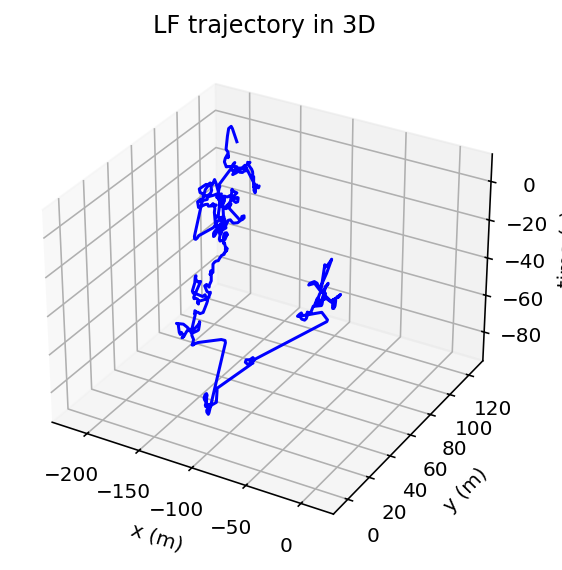
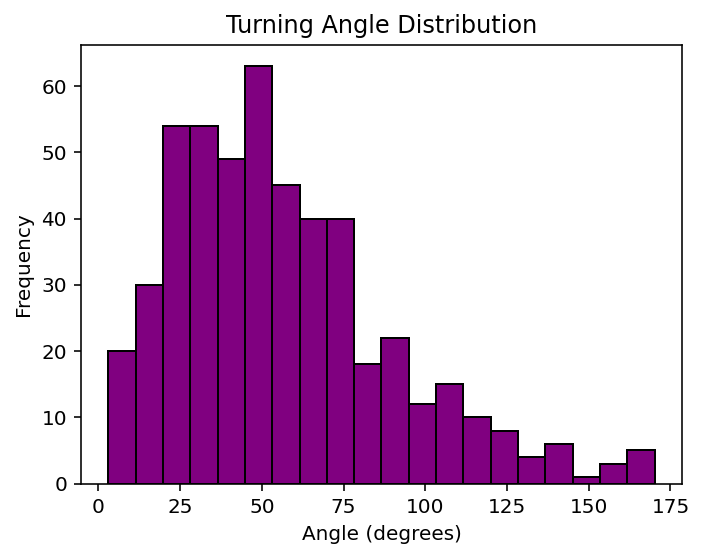

In [35]:
@pn.depends(traj_buttons, steps_slider, x_init_input, y_init_input, speed_slider, metric_dropdown, cauchy_c_input, alpha_input)
def update(traj_type, steps, x_init, y_init, speed, metric, cauchy_c, alpha):
    start_pos = [x_init, y_init, 0]
    
    #Parameters in each trajectory (BM, CRW & LF)
    if traj_type == "BM":
        traj = bm(steps, speed, start_pos)
    elif traj_type == "CRW":
        traj = crw(steps, speed, start_pos, cauchy_c)
    elif traj_type == "LF":
        traj = levy_f(steps, speed, start_pos, cauchy_c, alpha)
        
    fig_traj = plot_trajectory(traj, traj_type)
    fig_metric = plot_metric(traj, metric, traj_type)
    
    traj_panel = pn.pane.Matplotlib(fig_traj, tight=True, sizing_mode='scale_both')
    metric_panel = pn.pane.Matplotlib(fig_metric, tight=True, sizing_mode='scale_both')

    #Plot the trajectory values
    traj_box = pn.WidgetBox(
        traj_panel,
        sizing_mode='stretch_both',
        margin=(10, 10, 10, 10),
    )
    #Plot the metric values
    metric_box = pn.WidgetBox(
        metric_panel,
        sizing_mode='stretch_both',
        margin=(10, 10, 10, 10),
    )
    
    return pn.Row(traj_box, metric_box, sizing_mode='stretch_both')

#Each panel parameters in dashboard
controls = pn.WidgetBox(
    pn.pane.HTML("<h3 style='font-weight:bold;'>Panel Parameters</h3>"),
    traj_buttons,
    steps_slider,
    x_init_input,
    y_init_input,
    speed_slider,
    metric_dropdown,
    cauchy_c_input,
    alpha_input,
    width=350,
    margin=(10, 10, 10, 10)
)

dashboard = pn.Row(
    controls,
    pn.Spacer(width=20),
    update,
    sizing_mode='stretch_both'
)

dashboard.servable()